## Example BS100BW

In [22]:
# %% set gpu usage
from usbmd.tensorflow_ultrasound.utils.gpu_config import set_gpu_usage
set_gpu_usage(device='auto:1') #device = 5

0.875 GPUs were disabled
     memory
GPU        
0     23520
Selecting 1 GPUs based on available memory.
Selected GPU 0 with Free Memory: 23520.00 MiB


RuntimeError: Visible devices cannot be modified after being initialized

In [54]:
# %% load config
from pathlib import Path
from usbmd.utils.config import load_config_from_yaml
from usbmd.utils.config_validation import check_config
import os

# Load the config file
#config_path = Path.cwd() / 'configs/config_usbmd_dataset.yaml'
config_path = Path("D:\Beatrice_Federici\BMd_Ultrasound_Toolbox\configs\config_usbmd_rf.yaml")
#config_path = Path('configs', 'config_usbmd_rf.yaml')
config = load_config_from_yaml(config_path)
#config.scan.n_angles = [0] #list(range(128,128+5))

# Check the config file for errors
config = check_config(config)


In [82]:
# %% load dataset
from usbmd.data_format.usbmd_data_format import load_usbmd_file
import numpy as np

folder_path = config.data.dataset_folder
file_path = config.data.file_path
data_path = folder_path + '\\' + file_path
#data_path = r"Z:\Ultrasound-BMd\data\USBMD-example-data\planewave_l115v.hdf5"
# Load the data file and construct a probe and scan object
# We will only load the first two frames of the data file
data, scan, probe = load_usbmd_file(data_path, frames=[0], transmits = [3])


d:\beatrice_federici\bmd_ultrasound_toolbox\usbmd\utils\pixelgrid.py:49: UserWarning: width/Nx = 0.0002977 < wvln/2 = 9.856e-05. Consider increasing scan.Nx to 386 or more.
  warnings.warn(
d:\beatrice_federici\bmd_ultrasound_toolbox\usbmd\utils\pixelgrid.py:54: UserWarning: depth/Nz = 0.0002218 < wvln/2 = 0.0000986. Consider increasing scan.Nz to 288 or more.
  warnings.warn(


In [86]:
print(data.shape)
print(scan.Nx)
print(scan.Nz)
print(scan.n_ch)
print(scan.n_ax)
print(scan.n_tx)
print(scan.angles)
print(scan.modtype)
print(scan.initial_times)
print(scan.fdemod)
print(scan.fs)
print(scan.fc)
print(scan.bandwidth_percent)
print(probe.ele_pos.max())

print(config.data.modtype)

scan.Nz = 500
scan.Nx = 500
scan.initial_times = [np.abs(np.sin(np.deg2rad(np.linspace(-18, 18, 7)[3])))*probe.ele_pos.max()/scan.c]
scan.fs = scan.fc

print(scan.initial_times)
print(scan.fdemod)
print(scan.fs)
print(scan.fc)
print(probe.ele_pos)


(1, 1, 128, 576, 2)
500
500
2
576
1
[0.]
iq
[0.0]
7812500.0
7812500.0
7812500.0
100.0
0.01905
iq
[0.0]
7812500.0
7812500.0
7812500.0
[[-0.01905  0.       0.     ]
 [-0.01875  0.       0.     ]
 [-0.01845  0.       0.     ]
 [-0.01815  0.       0.     ]
 [-0.01785  0.       0.     ]
 [-0.01755  0.       0.     ]
 [-0.01725  0.       0.     ]
 [-0.01695  0.       0.     ]
 [-0.01665  0.       0.     ]
 [-0.01635  0.       0.     ]
 [-0.01605  0.       0.     ]
 [-0.01575  0.       0.     ]
 [-0.01545  0.       0.     ]
 [-0.01515  0.       0.     ]
 [-0.01485  0.       0.     ]
 [-0.01455  0.       0.     ]
 [-0.01425  0.       0.     ]
 [-0.01395  0.       0.     ]
 [-0.01365  0.       0.     ]
 [-0.01335  0.       0.     ]
 [-0.01305  0.       0.     ]
 [-0.01275  0.       0.     ]
 [-0.01245  0.       0.     ]
 [-0.01215  0.       0.     ]
 [-0.01185  0.       0.     ]
 [-0.01155  0.       0.     ]
 [-0.01125  0.       0.     ]
 [-0.01095  0.       0.     ]
 [-0.01065  0.       0.    

Text(0, 0.5, 'z [mm]')

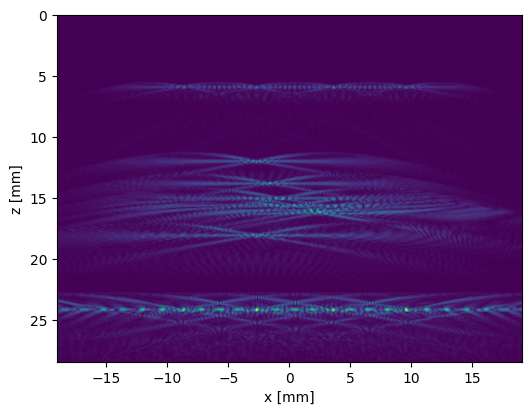

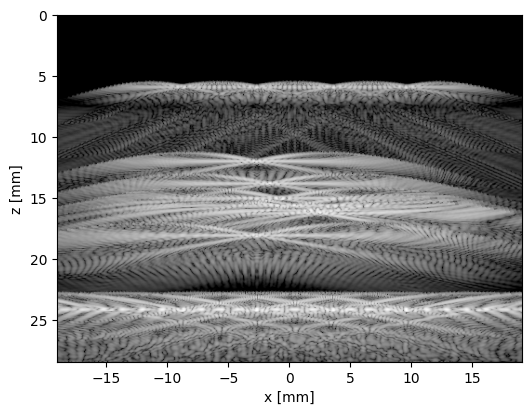

In [87]:
# %% beamforming RF data
from usbmd.tensorflow_ultrasound.layers.beamformers import get_beamformer
import tensorflow as tf
from usbmd.processing import rf2iq, log_compress
import matplotlib.pyplot as plt

# beamformer
beamformer = get_beamformer(probe=probe, scan=scan, config=config)
# beamform the data
beamformed_data = beamformer(data)[0]
# envelope
image = np.linalg.norm(beamformed_data, axis=-1)
# normalize
image = image / tf.reduce_max(image)
# log compression
image = 20 * tf.math.log(image) / tf.math.log(10.0)
# remove nan and inf
image = tf.where(tf.math.is_nan(image), config.data.dynamic_range[0], image)
image = tf.where(tf.math.is_inf(image), config.data.dynamic_range[0], image)
image = tf.clip_by_value(image, config.data.dynamic_range[0], 0)
# Plot the image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image,
          cmap='gray',
          extent=[scan.xlims[0]*1000, scan.xlims[1]*1000, scan.zlims[1]*1000, scan.zlims[0]*1000],
          vmin=config.data.dynamic_range[0],
          vmax=config.data.dynamic_range[1])
#ax.set_aspect('auto', adjustable='box')
# Add labels
ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')




